1. Import Required Libraries

cv2 (OpenCV) → for image processing and DNN inference.

numpy → handles array operations.

time → measures inference duration.

psutil → checks system memory usage.

matplotlib → used for data visualization

In [1]:
import cv2
import numpy as np
import time
import psutil
import matplotlib.pyplot as plt

2. Load YOLOV8 ONNX Model

Loads the YOLOv8 model in .onnx format.

cv2.dnn.readNet() creates a Deep Neural Network (DNN) object that can run inference.

In [2]:
model_path = "yolov8n.onnx"  
net = cv2.dnn.readNet(model_path)

3. Set Backend and Target

Uses OpenCV’s DNN backend for computations.

Runs on CPU (you could change to DNN_TARGET_CUDA if GPU support is configured).

In [3]:
# Use CPU (you can switch to CUDA if available)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

4. Load COCO Class Labels

Reads the COCO dataset class names

Each detected object will be labeled using these names, e.g. "person", "car", "dog", etc.

In [4]:
with open("coco.names", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

5. Image Preprocessing with Letterboxing

- YOLOv8 requires inputs to be square (e.g., 640×640) while keeping the original aspect ratio.
    
- letterbox() resizes the image and adds padding to fill any remaining space.

- Returns the resized image, scaling ratio, and padding offsets (dw, dh) needed to map detections back to the original image.

In [5]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114)):
    shape = img.shape[:2]  # height, width
    ratio = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(shape[1] * ratio), int(shape[0] * ratio))
    dw = new_shape[1] - new_unpad[0]
    dh = new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2

    img_resized = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh)), int(round(dh))
    left, right = int(round(dw)), int(round(dw))
    img_padded = cv2.copyMakeBorder(
        img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )
    return img_padded, ratio, left, top

6. Running Detection with OpenCV DNN

- Memory and time measurement: Tracks resource usage for analysis.

- Preprocessing: Applies letterbox resizing and creates a blob using cv2.dnn.blobFromImage().

  
        - Normalizes pixels to [0,1] with 1/255.0.
  
        - Swaps R and B channels (swapRB=True) because OpenCV uses BGR format by default.
            
- Inference: net.forward() runs the YOLOv8 model on the preprocessed image.

        - YOLOv8 outputs a large tensor containing bounding box predictions, confidence scores, and class probabilities.

In [6]:
def detect_objects(frame, display_width=800):
    input_size = 640

    # Measure start memory & time
    process = psutil.Process()
    mem_before = process.memory_info().rss / (1024 ** 2)
    start_time = time.time()

    # Preprocess
    img_letterboxed, ratio, dw, dh = letterbox(frame, new_shape=(input_size, input_size))
    blob = cv2.dnn.blobFromImage(
        img_letterboxed, 1/255.0, (input_size, input_size), swapRB=True, crop=False
    )
    net.setInput(blob)

    # Inference
    outputs = net.forward()

    # Measure end time & memory
    end_time = time.time()
    mem_after = process.memory_info().rss / (1024 ** 2)
    inference_time = end_time - start_time
    mem_used = mem_after - mem_before

    # Post-processing
    H, W, _ = frame.shape
    boxes, confidences, class_ids = [], [], []

    # Handle output shape variations
    if len(outputs.shape) == 3 and outputs.shape[1] == 25200 and outputs.shape[2] == 85:
        output = outputs[0]
    elif len(outputs.shape) == 3 and outputs.shape[1] == 84 and outputs.shape[2] == 8400:
        output = outputs[0].T
    elif len(outputs.shape) == 3 and outputs.shape[1] == 8400 and outputs.shape[2] == 85:
        output = outputs[0]
    else:
        raise ValueError(f"Unexpected output shape: {outputs.shape}")

    for detection in output:
        if output.shape[1] == 85:
            scores = detection[5:]
            objectness = detection[4]
            class_id = np.argmax(scores)
            confidence = objectness * scores[class_id]
        elif output.shape[1] == 84:
            scores = detection[4:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
        else:
            continue

        if confidence > 0.3:
            cx, cy, w, h = detection[0:4]
            cx *= input_size
            cy *= input_size
            w *= input_size
            h *= input_size

            x = int((cx - w / 2 - dw) / ratio)
            y = int((cy - h / 2 - dh) / ratio)
            w = int(w / ratio)
            h = int(h / ratio)

            x = max(0, x)
            y = max(0, y)
            w = min(W - x, w)
            h = min(H - y, h)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

    # Apply Non-Maximum Suppression (NMS)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)

    if len(indices) > 0:
        # Draw Boxes and Labels with larger text and thicker borders
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = class_names[class_ids[i]]
            confidence = confidences[i]
            color = (0, 255, 0)

            # Text setup — larger and bolder
            label_text = f"{label} {confidence:.2f}"
            font_scale = 2.5     # Increased font size
            font_thickness = 4   # Thicker text

            # Get text size
            (text_width, text_height), baseline = cv2.getTextSize(
                label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness
            )

            # Position text above box
            text_x = x
            text_y = y - 10
            if text_y < text_height:
                text_y = y + h + text_height + 10  # move below if near top

            # Draw white background rectangle behind text
            cv2.rectangle(
                frame,
                (text_x, text_y - text_height - baseline),
                (text_x + text_width, text_y + baseline),
                (255, 255, 255),
                cv2.FILLED
            )

            # Draw black text on white background
            cv2.putText(
                frame, label_text, (text_x, text_y),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness
            )

            # Draw bounding box (thicker for visibility)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 5)

    # Print performance stats
    print(f" Inference Time: {inference_time:.3f} seconds")
    print(f" Memory Used: {mem_used:.3f} MB")

    # Resize for display (maintain aspect ratio)
    h, w = frame.shape[:2]
    scale = display_width / w
    display_height = int(h * scale)
    resized_frame = cv2.resize(frame, (display_width, display_height))

    return resized_frame


7. Run Detection for Image

Example 1:

Processing: image1.jpg
 Inference Time: 0.099 seconds
 Memory Used: 103.082 MB
Displaying result for image1.jpg


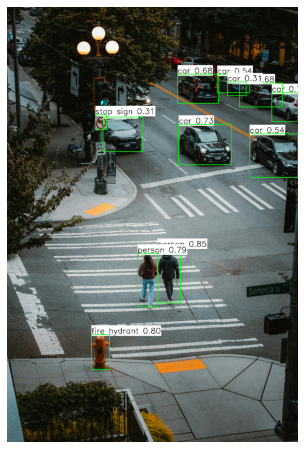

In [7]:
image_path = "image1.jpg" 

image = cv2.imread(image_path)
if image is None:
    print("Error: Image not found or unable to read.")
else:
    print(f"Processing: {image_path}")
    result = detect_objects(image)  

    print(f"Displaying result for {image_path}")

    # Display image in Jupyter Notebook
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(result_rgb)
    plt.axis('off')
    plt.show()


Example 2

Processing: image2.jpg
 Inference Time: 0.050 seconds
 Memory Used: 0.000 MB
Displaying result for image2.jpg


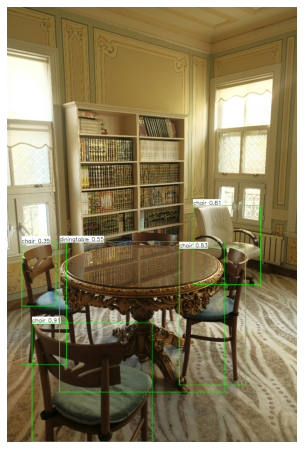

In [8]:
image_path = "image2.jpg" 

image = cv2.imread(image_path)
if image is None:
    print("Error: Image not found or unable to read.")
else:
    print(f"Processing: {image_path}")
    result = detect_objects(image)  

    print(f"Displaying result for {image_path}")

    # Display image in Jupyter Notebook
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(result_rgb)
    plt.axis('off')
    plt.show()
